In [4]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_scheduler
from seqeval.metrics import classification_report, f1_score
from spacy.training import offsets_to_biluo_tags
import spacy
from tqdm.auto import tqdm

nlp = spacy.blank("uk")

def get_labels_from_data(data):
    """Збирає всі унікальні теги."""
    unique_tags = set()
    for item in data:
        text = item['text']
        entities = item.get('entities', [])
        doc = nlp(text)
        tags = offsets_to_biluo_tags(doc, entities)
        for tag in tags:
            if tag == '-': unique_tags.add('O')
            else: unique_tags.add(tag.replace('U-', 'B-').replace('L-', 'I-'))

    if 'O' not in unique_tags: unique_tags.add('O')
    tag_list = sorted(list(unique_tags))
    if 'O' in tag_list:
        tag_list.remove('O')
        tag_list.insert(0, 'O')

    label2id = {tag: id for id, tag in enumerate(tag_list)}
    id2label = {id: tag for id, tag in enumerate(tag_list)}
    return label2id, id2label

def load_and_align_data(data, tokenizer, label2id):
    processed_data = []

    # --- ДІАГНОСТИЧНИЙ БЛОК: Дивимось на перший приклад ---
    print("\n--- [DIAGNOSIS START] Checking first example alignment ---")

    for i, item in enumerate(data):
        text = item['text']
        entities = item.get('entities', [])
        doc = nlp(text)
        tags = offsets_to_biluo_tags(doc, entities)

        # Конвертація BILUO -> IOB
        ner_tags = [tag if tag == '-' else tag.replace('U-', 'B-').replace('L-', 'I-') for tag in tags]
        ner_tags = ['O' if t == '-' else t for t in ner_tags]

        # Якщо це перший елемент, прінтанем його теги, щоб перевірити дані
        if i == 0:
            print(f"Text: {text}")
            print(f"Entities (JSON): {entities}")
            print(f"Aligned Tags (SpaCy): {ner_tags}")
            if all(t == 'O' for t in ner_tags) and len(entities) > 0:
                print("⚠️ WARNING: SpaCy converted all entities to 'O'! Check your start/end indices.")

        words = [token.text for token in doc]
        tokenized_input = tokenizer(
            words, is_split_into_words=True, truncation=True,
            padding='max_length', max_length=128, return_tensors="pt"
        )

        word_ids = tokenized_input.word_ids()
        label_ids = []
        prev_idx = None
        for word_idx in word_ids:
            if word_idx is None: label_ids.append(-100)
            elif word_idx != prev_idx:
                label_ids.append(label2id[ner_tags[word_idx]])
            else: label_ids.append(-100)
            prev_idx = word_idx

        processed_data.append({
            "input_ids": tokenized_input["input_ids"][0],
            "attention_mask": tokenized_input["attention_mask"][0],
            "labels": torch.tensor(label_ids, dtype=torch.long)
        })

    print("--- [DIAGNOSIS END] ---\n")
    return processed_data

def evaluate_metrics(model, dataloader, id2label, device):
    model.eval()
    true_labels, predictions = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)

            for i in range(len(labels)):
                t_sent, p_sent = [], []
                for j in range(len(labels[i])):
                    if labels[i][j] != -100:
                        t_sent.append(id2label[labels[i][j].item()])
                        p_sent.append(id2label[preds[i][j].item()])
                true_labels.append(t_sent)
                predictions.append(p_sent)

    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0

    report = classification_report(true_labels, predictions, output_dict=True, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)

    gpe_acc = report.get('GPE', {}).get('recall', 0.0)
    loc_acc = report.get('LOC', {}).get('recall', 0.0)

    return avg_loss, f1, gpe_acc, loc_acc

def plot_dashboard():
    epochs = range(1, NUM_EPOCHS + 1)
    fig, axs = plt.subplots(2, 4, figsize=(22, 10))
    fig.suptitle('NER Dashboard (Aggressive Training)', fontsize=16)

    def plot_m(ax, data, title, color):
        ax.plot(epochs, data, color, marker='o')
        ax.set_title(title)
        ax.grid(True)

    # TRAIN
    axs[0, 0].plot(epochs, history['train']['loss'], 'r-o'); axs[0, 0].set_title('Train Loss'); axs[0, 0].grid(True)
    plot_m(axs[0, 1], history['train']['f1'], 'Train F1', 'b')
    plot_m(axs[0, 2], history['train']['gpe_acc'], 'Train GPE Recall', 'g')
    plot_m(axs[0, 3], history['train']['loc_acc'], 'Train LOC Recall', 'm')

    # TEST
    axs[1, 0].plot(epochs, history['test']['loss'], 'r--o'); axs[1, 0].set_title('Test Loss'); axs[1, 0].grid(True)
    plot_m(axs[1, 1], history['test']['f1'], 'Test F1', 'b--')
    plot_m(axs[1, 2], history['test']['gpe_acc'], 'Test GPE Recall', 'g--')
    plot_m(axs[1, 3], history['test']['loc_acc'], 'Test LOC Recall', 'm--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("metrics_dashboard_aggressive.png")
    print(f"\nGraph saved.")
    plt.show()

Using device: cuda
Loading data...
Detected Labels: ['O', 'B-GPE', 'B-LOC', 'I-GPE', 'I-LOC']


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at ukr-models/uk-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- [DIAGNOSIS START] Checking first example alignment ---
Text: Селище Гладосове розташоване неподалік від лінії розмежування в Донецькій області.
Entities (JSON): [[7, 16, 'GPE'], [60, 77, 'LOC']]
Aligned Tags (SpaCy): ['O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
--- [DIAGNOSIS END] ---

Starting training for 30 epochs...


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5 | Train F1: 0.29 | Test F1: 0.00
Epoch 10 | Train F1: 0.54 | Test F1: 0.00
Epoch 15 | Train F1: 0.91 | Test F1: 1.00
Epoch 20 | Train F1: 0.91 | Test F1: 1.00
Epoch 25 | Train F1: 0.91 | Test F1: 0.67
Epoch 30 | Train F1: 0.91 | Test F1: 0.67
Saving model to models/my_finetuned_ner...

Graph saved.


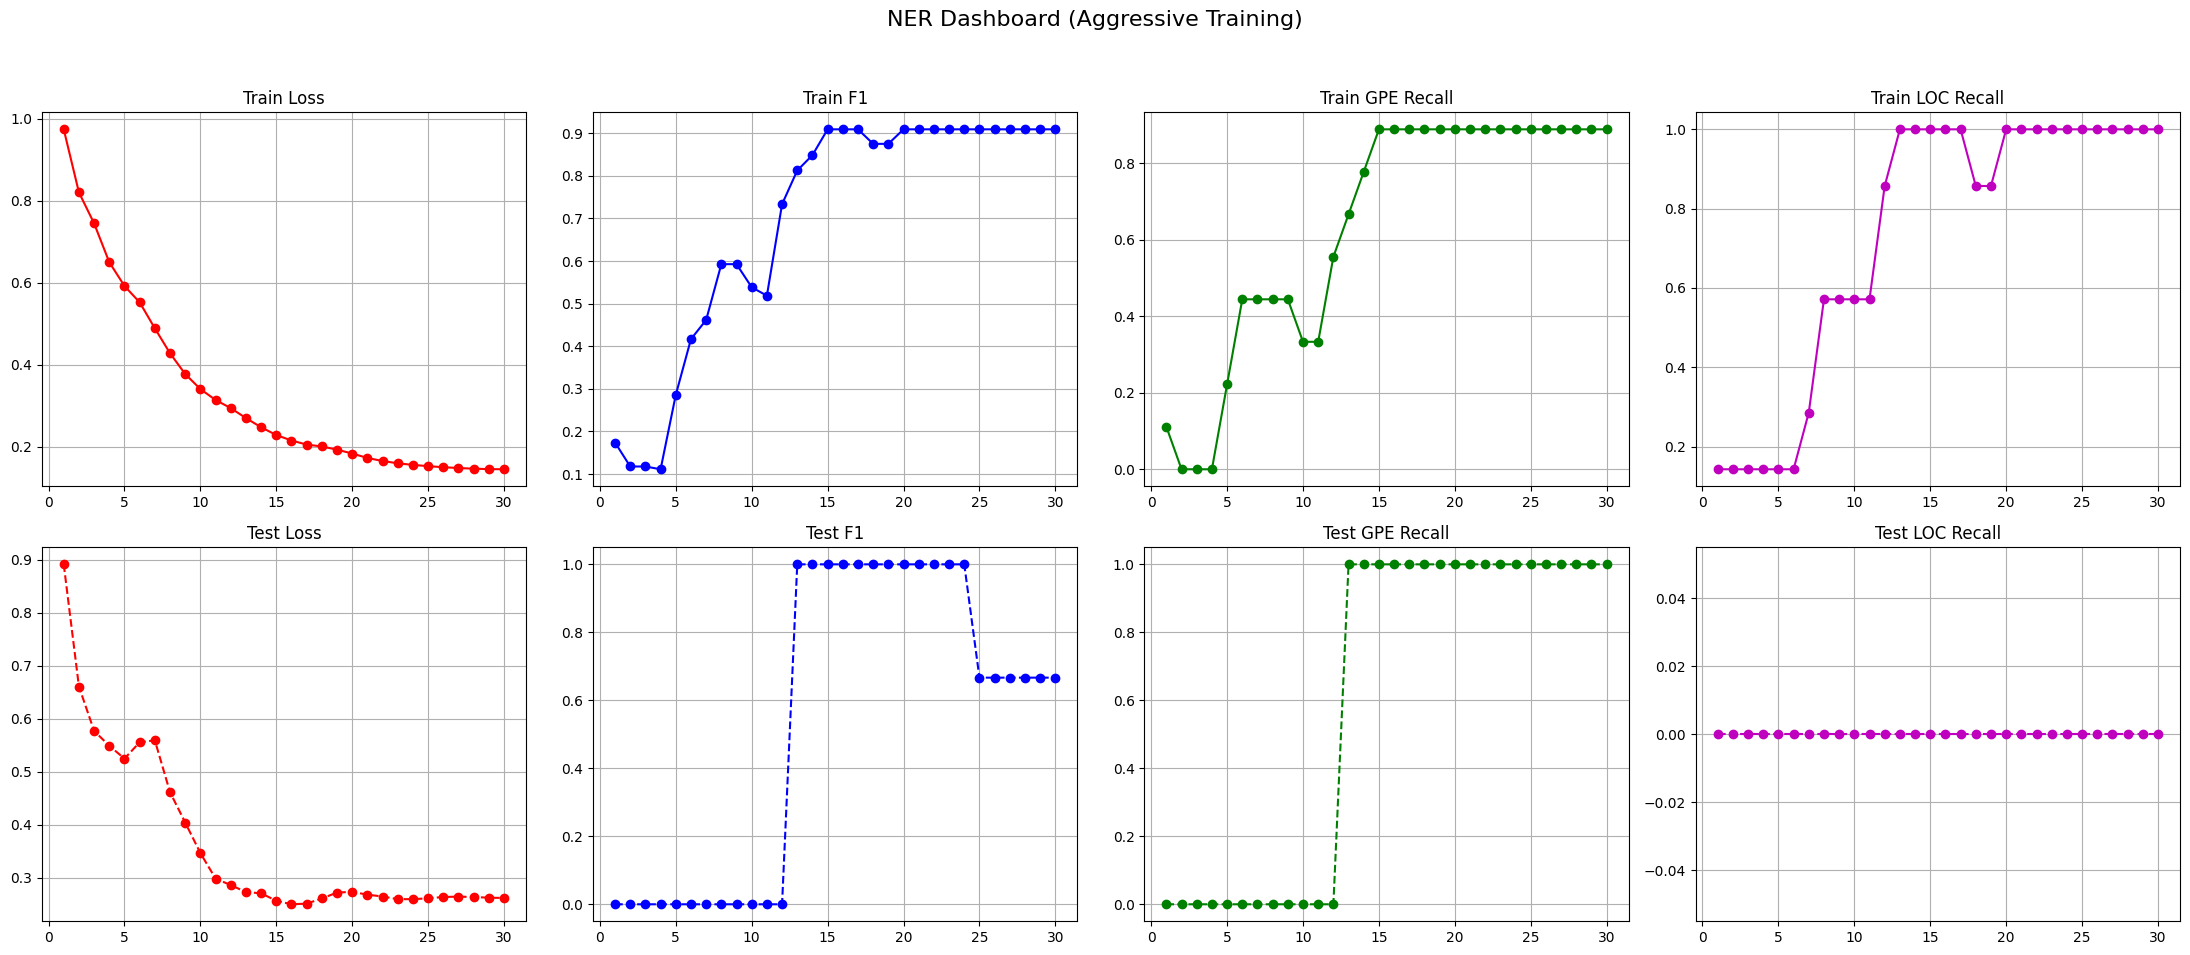

In [9]:
MODEL_NAME = "ukr-models/uk-ner"
DATA_FILE = "data/test_dataset.json"
OUTPUT_DIR = "models/my_finetuned_ner"
NUM_EPOCHS = 30
BATCH_SIZE = 4
LEARNING_RATE = 5e-5

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

print("Loading data...")
with open(DATA_FILE, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

label2id, id2label = get_labels_from_data(raw_data)
print(f"Detected Labels: {list(label2id.keys())}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(label2id), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
model.to(device)

dataset = load_and_align_data(raw_data, tokenizer, label2id)


split_idx = int(len(dataset) * 0.9)
train_data = dataset[:split_idx]
test_data = dataset[split_idx:]

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_eval_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = NUM_EPOCHS * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

print(f"Starting training for {NUM_EPOCHS} epochs...")
progress_bar = tqdm(range(num_training_steps))

history = {
    "train": {"loss": [], "f1": [], "gpe_acc": [], "loc_acc": []},
    "test":  {"loss": [], "f1": [], "gpe_acc": [], "loc_acc": []}
}


for epoch in range(NUM_EPOCHS):
    model.train()
    for batch in train_loader:
        input_ids, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=mask, labels=labels)
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    tr_loss, tr_f1, tr_gpe, tr_loc = evaluate_metrics(model, train_eval_loader, id2label, device)
    te_loss, te_f1, te_gpe, te_loc = evaluate_metrics(model, test_loader, id2label, device)

    history['train']['loss'].append(tr_loss); history['train']['f1'].append(tr_f1)
    history['train']['gpe_acc'].append(tr_gpe); history['train']['loc_acc'].append(tr_loc)

    history['test']['loss'].append(te_loss); history['test']['f1'].append(te_f1)
    history['test']['gpe_acc'].append(te_gpe); history['test']['loc_acc'].append(te_loc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Train F1: {tr_f1:.2f} | Test F1: {te_f1:.2f}")

print(f"Saving model to {OUTPUT_DIR}...")
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
plot_dashboard()